### Simple metrics
- Weighted average
- Median
- Variance
- Annual root mean squared error (RMSE)

Outliers are always removed, VOLL = 9e06, large impact on metrics.

In [39]:
import pandas as pd
import numpy as np

# Define the range of years
years = range(2012, 2022)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over the years
for year in years:
    # Read the empirical prices
    empirical_prices = pd.read_csv(f"{year}prices_emp.csv")
    
    # Read the synthetic prices and add a Time_Index column
    synthetic_prices = pd.read_csv(f"{year}prices.csv")
    synthetic_prices['Time_Index'] = synthetic_prices.index + 1
    
    # Read the weights
    weights = pd.read_csv(f"{year}Load_data.csv")

    # # Exclude the n highest prices from synthetic dataset, and the corresponding prices from the empirical dataset
    # n = 15
    # synthetic_prices_excluded = synthetic_prices.nsmallest(len(synthetic_prices) - n, "1")
    # # sort the synthetic prices by index
    # synthetic_prices_excluded = synthetic_prices_excluded.sort_values(by=['Time_Index'])
    # empirical_prices_excluded = empirical_prices.loc[empirical_prices.index.isin(synthetic_prices_excluded.index)]

    synthetic_prices_excluded = synthetic_prices
    empirical_prices_excluded = empirical_prices

    # clip the highest prices from the synthetic dataset to nsynt
    nsynth = 1000
    synthetic_prices_excluded['1'] = synthetic_prices['1'].clip(upper=nsynth)
    clipped_prices_synth = synthetic_prices_excluded[synthetic_prices_excluded['1'] == nsynth]
    
    # clip the empirical prices to nemp. Count the number of prices that are clipped
    nemp = 1000
    empirical_prices_excluded['Price'] = empirical_prices['Price'].clip(upper=nemp)
    clipped_prices_emp = empirical_prices_excluded[empirical_prices_excluded['Price'] == nemp]

    # Merge the data based on Time_Index
    merged_data = empirical_prices_excluded.merge(synthetic_prices_excluded, on='Time_Index').merge(weights, on='Time_Index')
    
    # Calculate the weighted average for empirical prices
    empirical_weighted_avg = (merged_data['Price'] * merged_data['Load_MW_z1']).sum() / merged_data['Load_MW_z1'].sum()

    # Calculate the median for empirical prices (excluding the highest prices)
    empirical_median = np.median(empirical_prices_excluded['Price'])
    
    # Calculate the variance for empirical prices (excluding the highest prices)
    empirical_variance = empirical_prices_excluded['Price'].var()

    # Calculate the weighted average for synthetic prices
    synthetic_weighted_avg = (merged_data['1'] * merged_data['Load_MW_z1']).sum() / merged_data['Load_MW_z1'].sum()
    
    # Calculate the median for synthetic prices (excluding the highest prices)
    synthetic_median = np.median(synthetic_prices_excluded['1'])

    # Calculate the variance for synthetic prices (excluding the highest prices)
    synthetic_variance = synthetic_prices_excluded['1'].var()
    
    # Calculate the difference between the weighted averages
    weighted_avg_diff = empirical_weighted_avg - synthetic_weighted_avg
    
    # Calculate the difference between the medians
    median_diff = empirical_median - synthetic_median

    # Calculate the difference between the variances
    variance_diff = empirical_variance - synthetic_variance

    # Calculate the root mean squared error between the empirical and synthetic prices, excluding the highest prices
    rmse = np.sqrt(((empirical_prices_excluded['Price'] - synthetic_prices_excluded['1']) ** 2).mean())
    
    # Print the results for the year
    print(f"Year: {year}")
    print(f"Number of empirical prices clipped: {len(clipped_prices_emp)}")
    print(f"Number of synthetic prices clipped: {len(clipped_prices_synth)}")
    print(f"Empirical weighted Average: {empirical_weighted_avg}")
    print(f"Synthetic weighted Average: {synthetic_weighted_avg}")
    print(f"Average Difference: {weighted_avg_diff}")
    print(f"Empirical Median: {empirical_median}")
    print(f"Synthetic Median: {synthetic_median}")
    print(f"Median Difference: {median_diff}")
    print(f"Empirical Variance: {empirical_variance}")
    print(f"Synthetic Variance: {synthetic_variance}")
    print(f"Variance Difference: {variance_diff}")
    print(f"RMSE: {rmse}\n")

    # # Save each year price difference to a csv file
    # price_difference = pd.DataFrame({f'{year}Price Difference': empirical_prices_excluded['Price'] - synthetic_prices_excluded['1'],
    #                                  'Time_Index': synthetic_prices['Time_Index']})
    # price_file = pd.read_csv("price_diff.csv")

    # # Drop the columns from the price_diff file that already exist in the new price_diff DataFrame
    # existing_columns = [col for col in price_difference.columns if col in price_file.columns]
    # price_file = price_file.drop(columns=existing_columns)

    # # Concatenate the price_file and price_difference DataFrames along the columns axis
    # price_file = pd.concat([price_file, price_difference], axis=1)

    # # Save the updated DataFrame to the price_diff.csv file
    # price_file.to_csv("price_diff.csv", index=False)
    
    # Create a DataFrame for the current year's metrics
    year_metrics = pd.DataFrame({'Year': [year],
                                 'Empirical Average': [empirical_weighted_avg],
                                 'Synthetic Average': [synthetic_weighted_avg],
                                 'Average Difference': [weighted_avg_diff],
                                 'Empirical Median': [empirical_median],
                                 'Synthetic Median': [synthetic_median],
                                 'Median Difference': [median_diff],
                                 'Empirical Variance': [empirical_variance],
                                 'Synthetic Variance': [synthetic_variance],
                                 'Variance Difference': [variance_diff],
                                 'RMSE': [rmse]})
    
    # Concatenate the year's metrics with the existing results DataFrame
    results_df = pd.concat([results_df, year_metrics], ignore_index=True)

# Read the existing metrics_simple.csv file
existing_metrics = pd.read_csv('metrics_simple.csv')

# Delete the previous results for this metric, if they exist. Drop everything except the "Year" column
if 'Empirical Average' in existing_metrics.columns:
    existing_metrics = existing_metrics.drop(columns=['Empirical Average',
                                                      'Synthetic Average',
                                                      'Average Difference',
                                                      'Empirical Median',
                                                      'Synthetic Median',
                                                      'Median Difference',
                                                      'Empirical Variance',
                                                      'Synthetic Variance',
                                                      'Variance Difference',
                                                      'RMSE'])


# Merge the existing metrics with the new results based on the "Year" column
merged_metrics = existing_metrics.merge(results_df, on='Year')

# Save the merged metrics to the metrics_simple.csv file
merged_metrics.to_csv('metrics_simple.csv', index=False)

Year: 2012
Number of empirical prices clipped: 5
Number of synthetic prices clipped: 0
Empirical weighted Average: 30.14712656187978
Synthetic weighted Average: 31.680731616091563
Average Difference: -1.5336050542117832
Empirical Median: 23.0
Synthetic Median: 29.34384
Median Difference: -6.34384
Empirical Variance: 1134.869754774784
Synthetic Variance: 158.72590133472204
Variance Difference: 976.143853440062
RMSE: 31.724750105933886

Year: 2013
Number of empirical prices clipped: 0
Number of synthetic prices clipped: 0
Empirical weighted Average: 34.028765515032305
Synthetic weighted Average: 37.37711365899697
Average Difference: -3.348348143964664
Empirical Median: 29.55
Synthetic Median: 33.423753999999995
Median Difference: -3.8737539999999946
Empirical Variance: 235.515465867373
Synthetic Variance: 182.27268159881703
Variance Difference: 53.242784268555965
RMSE: 14.553608465216655

Year: 2014
Number of empirical prices clipped: 2
Number of synthetic prices clipped: 0
Empirical wei

### Pearson, Spearman 
- Annual coefficients
- Daily coefficients

In [48]:
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Define the range of years
years = range(2012, 2022)

# Create an empty list to store the correlation coefficients
daily_coefficients = pd.DataFrame()
annual_coefficients = pd.DataFrame()

# Iterate over the years
for year in years:
    # Read the empirical prices
    empirical_prices = pd.read_csv(f"{year}prices_emp.csv")
    
    # Read the synthetic prices
    synthetic_prices = pd.read_csv(f"{year}prices.csv")
    synthetic_prices['Time_Index'] = synthetic_prices.index + 1

    empirical_prices_excluded = empirical_prices
    synthetic_prices_excluded = synthetic_prices
    
    # clip the highest prices from the synthetic dataset to nsynt
    nsynth = 1000
    synthetic_prices_excluded['1'] = synthetic_prices['1'].clip(upper=nsynth)
    clipped_prices_synth = synthetic_prices_excluded[synthetic_prices_excluded['1'] == nsynth]
    
    # clip the empirical prices to nemp. Count the number of prices that are clipped
    nemp = 100000000
    empirical_prices_excluded['Price'] = empirical_prices['Price'].clip(upper=nemp)
    clipped_prices_emp = empirical_prices_excluded[empirical_prices_excluded['Price'] == nemp]  

    # Extract the price columns
    empirical_price_column = empirical_prices_excluded["Price"]
    synthetic_price_column = synthetic_prices_excluded["1"]
    
    # Compute the Pearson and Spearman correlation
    pearson_annual, _ = pearsonr(empirical_price_column, synthetic_price_column)
    spearman_annual, _ = spearmanr(empirical_price_column, synthetic_price_column)

    step_size = 24
    pearson_daily = []
    spearman_daily = []
    days = []
    for i in range(0, len(empirical_price_column), step_size):
        y1 = empirical_price_column.iloc[i:i+step_size]
        y2 = synthetic_price_column.iloc[i:i+step_size]
        p_corr, _ = pearsonr(y1, y2)
        s_corr, _ = spearmanr(y1, y2)
        pearson_daily.append(p_corr)
        spearman_daily.append(s_corr)
        days.append(i/24+1)
    
    # Concatenate the year's annual coefficients with the existing annual_coefficients DataFrame
    annual_coefficients = pd.concat([annual_coefficients, pd.DataFrame({'Year': [year],
                                                                        'Pearson annual': [pearson_annual],
                                                                        'Spearman annual': [spearman_annual]})
                                        ], ignore_index=True)
    
    # Add the daily pearson and spearman coefficients to the existing dataframe
    if 'Day' in daily_coefficients.columns:
        daily_coefficients = daily_coefficients.drop(columns=['Day'])
    daily_coefficients[f'{year}Pearson daily'] = pearson_daily
    daily_coefficients[f'{year}Spearman daily'] = spearman_daily
    daily_coefficients['Day'] = days

    print(f"Year: {year}")
    print(f"Annual Pearson: {pearson_annual}")
    print(f"Annual Spearman: {spearman_annual}")

# Read the existing files
existing_annual_coefficients = pd.read_csv('annual_coefficients.csv')
existing_daily_coefficients = pd.read_csv('daily_coefficients.csv')

# Delete the previous results, if they exist. Drop everything except the "Year" (or Day) column
if 'Pearson annual' in existing_annual_coefficients.columns:
    existing_annual_coefficients = existing_annual_coefficients.drop(columns=['Pearson annual',
                                                                              'Spearman annual'])
if '2012Pearson daily' in existing_daily_coefficients.columns:
    for year in years:
        existing_daily_coefficients = existing_daily_coefficients.drop(columns=[f'{year}Pearson daily',
                                                                            f'{year}Spearman daily'])

# Merge the existing results with the new results based on the "Year" (or Day) column
merged_annual_coefficients = existing_annual_coefficients.merge(annual_coefficients, on='Year')
merged_daily_coefficients = existing_daily_coefficients.merge(daily_coefficients, on='Day')
# merged_spearman_coefficients = existing_spearman_coefficients.merge(spearman_coefficients, on='Day')

# Save the merged coefficients to the files
merged_annual_coefficients.to_csv('annual_coefficients.csv', index=False)
merged_daily_coefficients.to_csv('daily_coefficients.csv', index=False)
# merged_spearman_coefficients.to_csv('spearman_daily.csv', index=False)

Year: 2012
Annual Pearson: 0.329600925916111
Annual Spearman: 0.7854377816979536
Year: 2013
Annual Pearson: 0.5311706668719767
Annual Spearman: 0.8128515412323118
Year: 2014
Annual Pearson: 0.4453943528289278
Annual Spearman: 0.822131592188628
Year: 2015
Annual Pearson: 0.3184625489454987
Annual Spearman: 0.7959977528137149
Year: 2016
Annual Pearson: 0.617739525723477
Annual Spearman: 0.7882477244358652
Year: 2017
Annual Pearson: 0.5826641088387668
Annual Spearman: 0.8367558400868852
Year: 2018
Annual Pearson: 0.6061424370258243
Annual Spearman: 0.8513461986408772
Year: 2019
Annual Pearson: 0.3854875819351703
Annual Spearman: 0.8424196324457446
Year: 2020
Annual Pearson: 0.7400292773275131
Annual Spearman: 0.797249095373774
Year: 2021
Annual Pearson: 0.39238146939508345
Annual Spearman: 0.8518968851784177


### Price Distribution
- Find a nice way to present it
- KS (Kolmogorov-Smirnov) test (the lower the better). Takes into account shape + median
- Bucket from The Future of Energy Storage 
  - 0-5: Renewables
  - 5-50: Gas CC
  - 50-200: Gas peak
  - 200-1000: Storage
  - \>1000: Scarcity
- Adding P(genx=emp). GenX=Emp if within a 25% range?
- Plotting GenX function of empirical 
- KL (Kullback-Leibler) divergence (complicated)

22.51
22.05
21.662
21.26
20.89
20.52
20.098000000000003
19.712
19.22
18.79
18.33
17.88
17.37
16.89
16.24
15.604000000000001
14.97
14.21
12.956000000000001
8.01


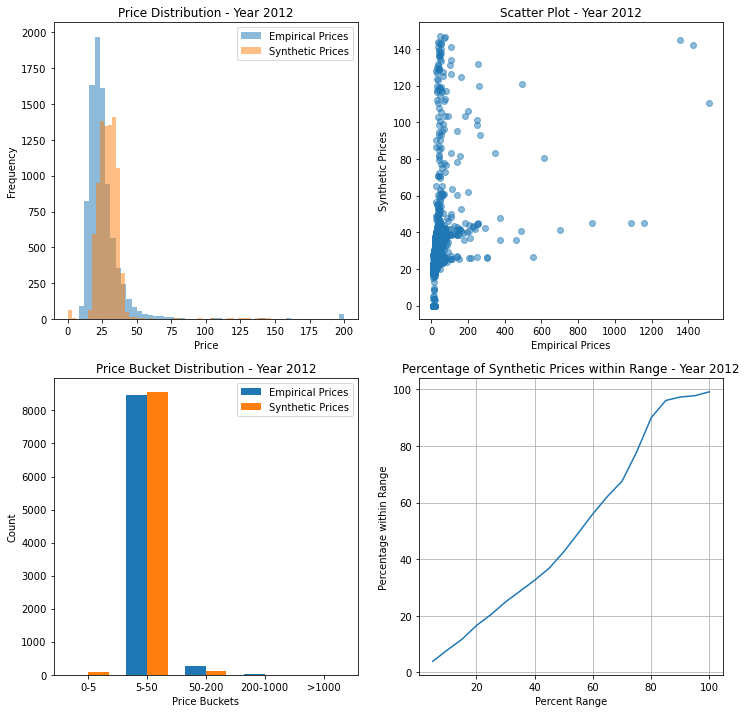

Year: 2012
KS Statistic: 0.3421232876712329
P-value: 0.0
28.99
28.5
27.99
27.44
26.87
26.35
25.9
25.33
24.876000000000005
24.29
23.624000000000002
23.1
22.58
22.04
21.54
21.01
20.48
19.842000000000002
18.43
11.42


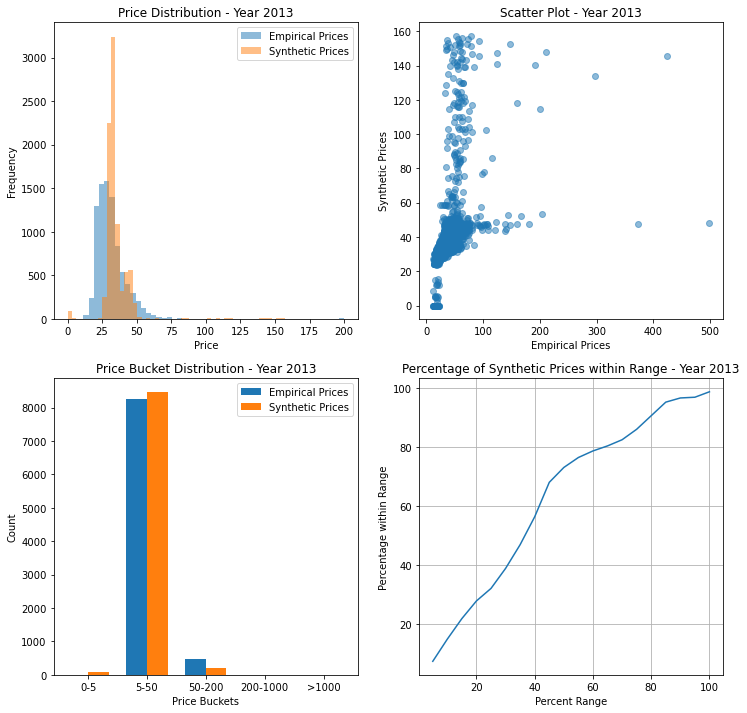

Year: 2013
KS Statistic: 0.413013698630137
P-value: 0.0
32.337999999999994
31.688000000000002
31.0
30.366000000000003
29.91
29.403999999999996
28.77
28.241999999999997
27.746000000000002
27.19
26.61
26.0
25.412
24.9
24.29
23.5
22.668
21.5
19.81
5.02


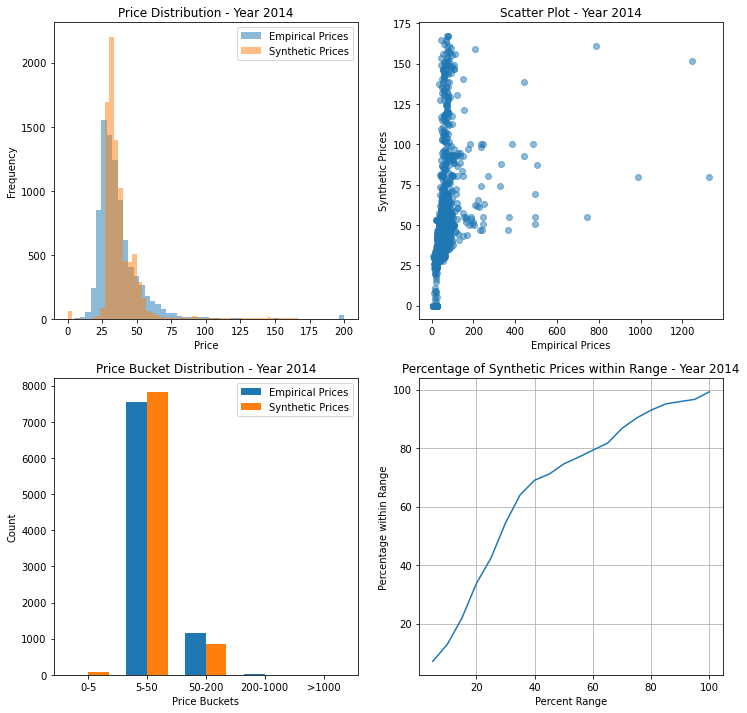

Year: 2014
KS Statistic: 0.2802511415525114
P-value: 3.001450840312674e-303
21.29
21.0
20.67
20.28
19.97
19.573999999999995
19.2
18.862
18.49
18.14
17.874000000000002
17.5
17.05
16.6
16.03
15.37
14.66
13.494000000000002
11.226
3.6


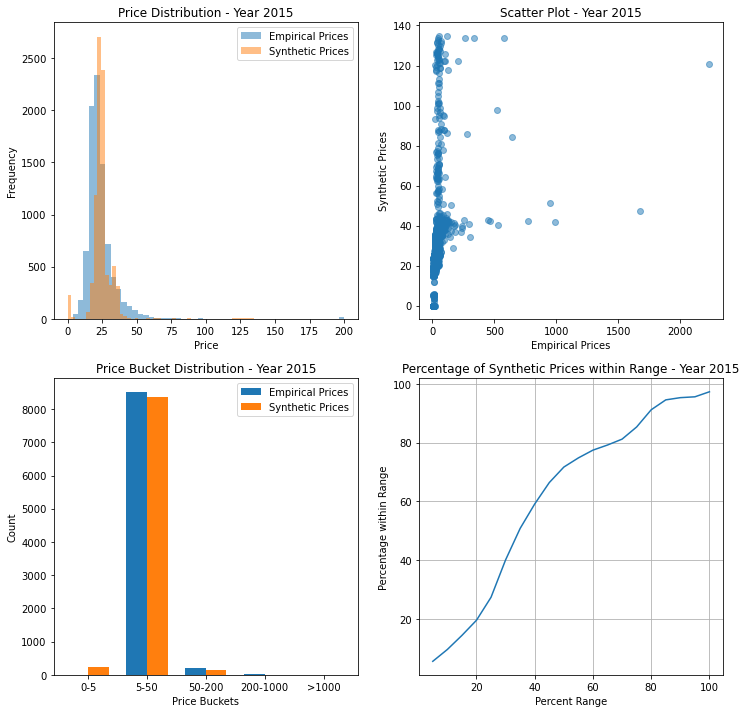

Year: 2015
KS Statistic: 0.2850456621004566
P-value: 7.5539524616e-314
19.24
18.81
18.45
18.06
17.79
17.443999999999996
17.1
16.81
16.42
16.0
15.58
15.08
14.6
14.0
13.28
12.3
11.408
9.91
6.05
1.18


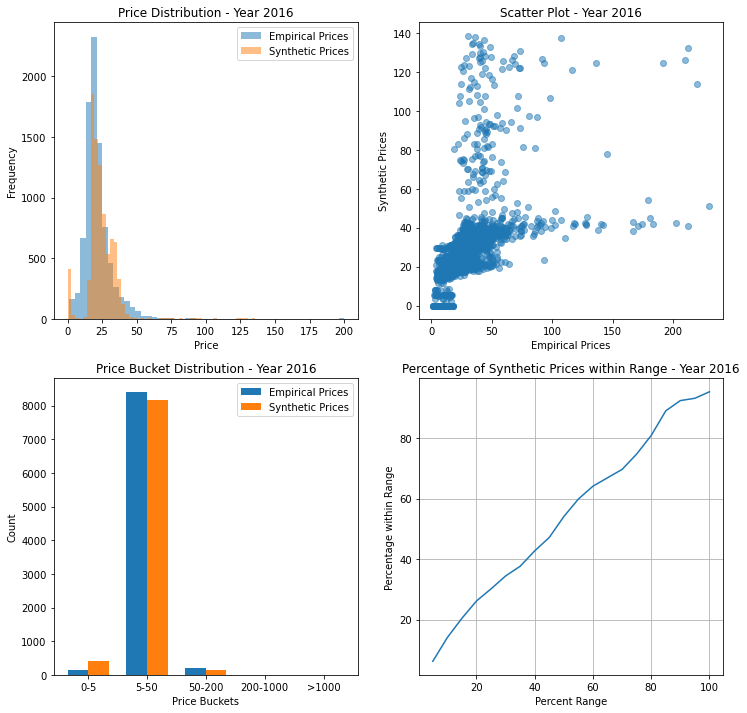

Year: 2016
KS Statistic: 0.23230593607305935
P-value: 1.3058824537369938e-207
21.693999999999996
21.42
21.09
20.82
20.54
20.28
20.01
19.75
19.45
19.17
18.87
18.57
18.22
17.836
17.42
16.95
16.05
14.486000000000002
10.866
1.94


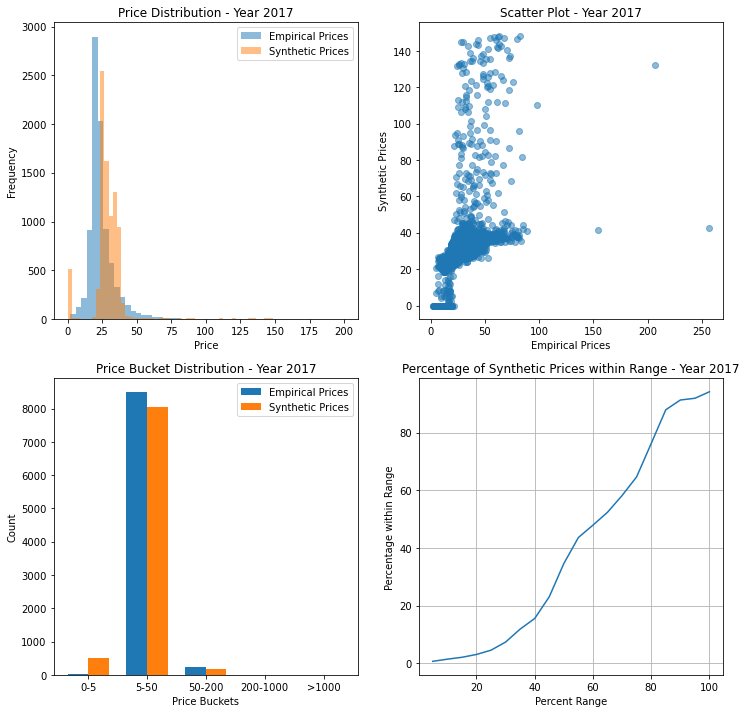

Year: 2017
KS Statistic: 0.5141552511415525
P-value: 0.0
24.01
23.47
22.96
22.436000000000003
21.97
21.5
21.07
20.66
20.19
19.8
19.45
19.01
18.592
18.17
17.71
17.144000000000002
16.47
15.25
12.44
5.09


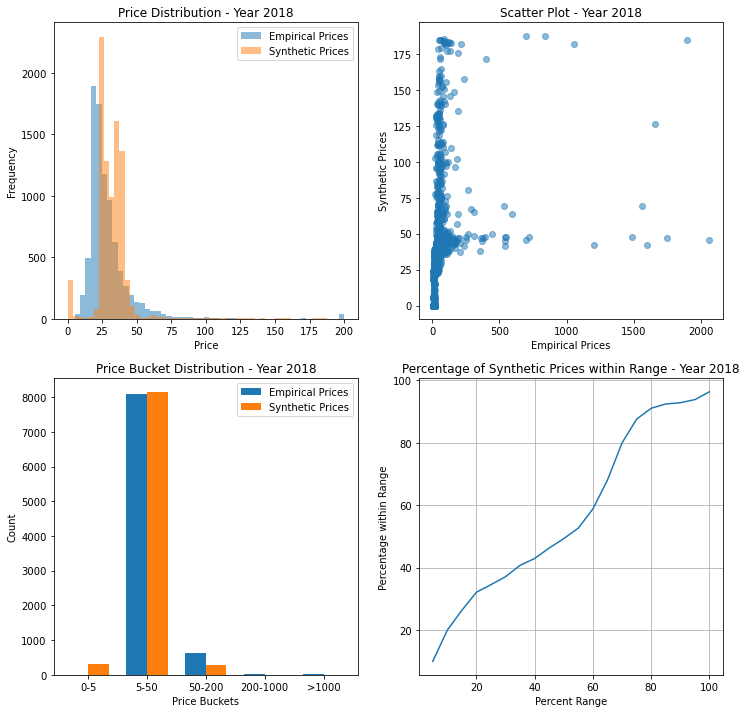

Year: 2018
KS Statistic: 0.35924657534246573
P-value: 0.0
20.083999999999996
19.728
19.37
19.056000000000004
18.71
18.33
17.94
17.57
17.18
16.81
16.4
15.94
15.541999999999998
15.02
14.54
14.0
13.26
12.38
10.444
3.26


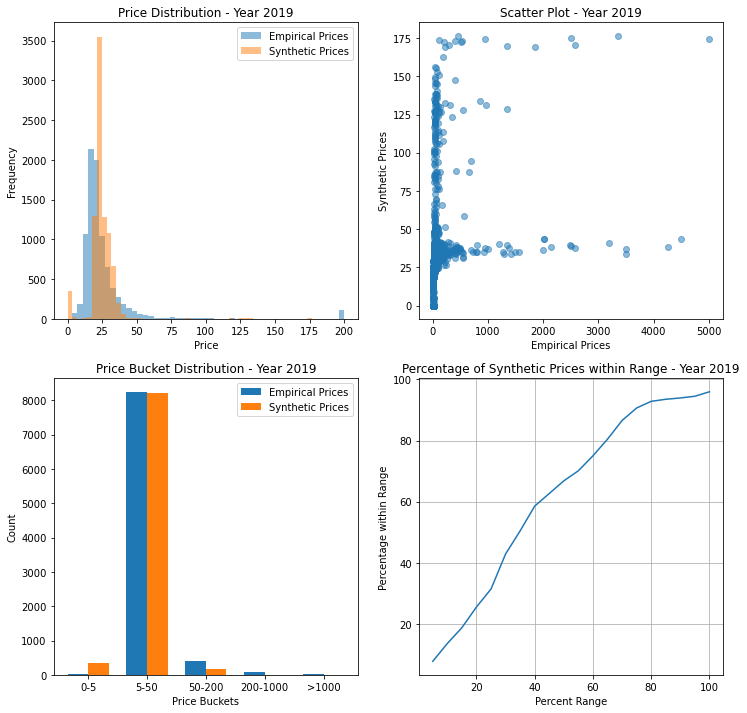

Year: 2019
KS Statistic: 0.37945205479452054
P-value: 0.0
17.11
16.75
16.37
16.03
15.65
15.28
14.96
14.61
14.28
13.93
13.59
13.24
12.741999999999999
12.315999999999999
11.84
11.33
10.73
9.802000000000001
7.99
3.31


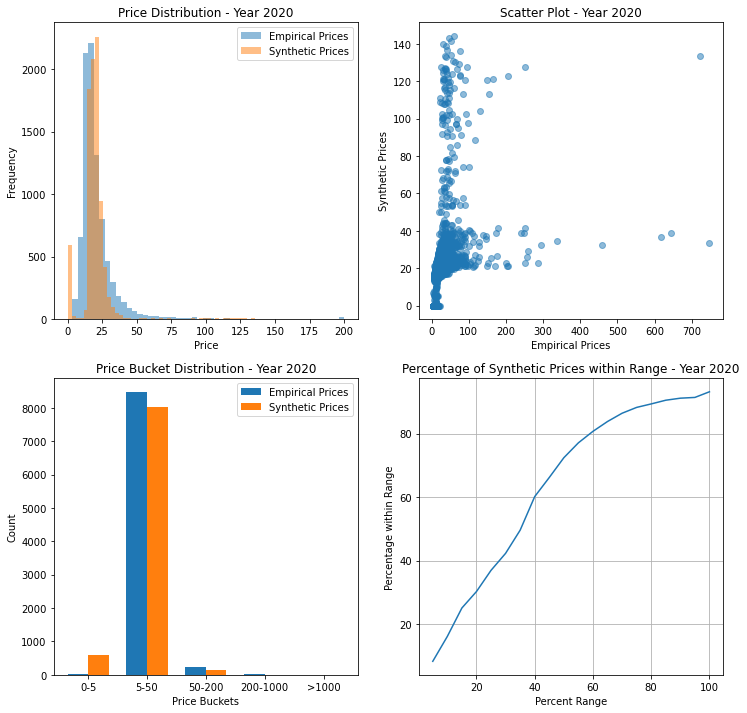

Year: 2020
KS Statistic: 0.258675799086758
P-value: 6.799813341020406e-258
27.01
26.25
25.48
24.866000000000003
24.14
23.443999999999996
22.72
21.962
21.286000000000005
20.55
19.91
19.228
18.57
18.0
17.42
16.58
15.548
13.85
9.670000000000002
-0.12


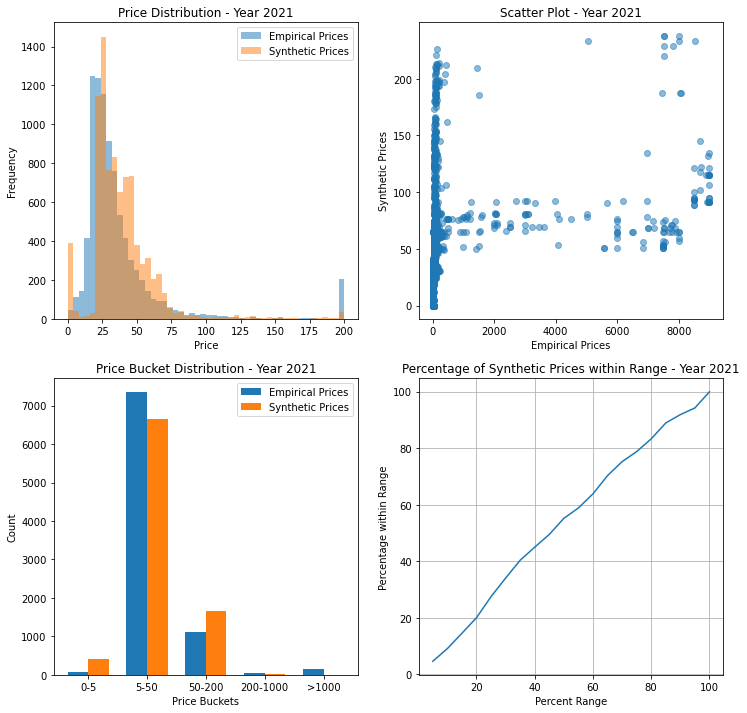

Year: 2021
KS Statistic: 0.21689497716894976
P-value: 8.094636461080742e-181


PermissionError: [Errno 13] Permission denied: 'ks_metrics.csv'

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Define the range of years
years = range(2012, 2022)

# Percentage range
increment = 5
max_range = 100

# Define the price buckets
buckets = ["0-5", "5-50", "50-200", "200-1000", ">1000"]

# Create an empty list to store the correlation coefficients
ks_statistics = []
p_values = []
year_list = []

# Iterate over the years
for year in years:
    # Read the empirical prices
    empirical_prices = pd.read_csv(f"{year}prices_emp.csv")
    
    # Read the synthetic prices
    synthetic_prices = pd.read_csv(f"{year}prices.csv")
    synthetic_prices['Time_Index'] = synthetic_prices.index + 1

    # Perform the KS test
    ks_stat, p_value = ks_2samp(empirical_prices["Price"], synthetic_prices["1"])

    # Append the KS metrics and year to the respective lists
    ks_statistics.append(ks_stat)
    p_values.append(p_value)
    year_list.append(year)
    
    # Exclude the n highest prices from synthetic dataset, and the corresponding prices from the empirical dataset
    n = 15
    synthetic_prices_excluded = synthetic_prices.nsmallest(len(synthetic_prices) - n, "1")
    # sort the synthetic prices by index
    synthetic_prices_excluded = synthetic_prices_excluded.sort_values(by=['Time_Index'])
    empirical_prices_excluded = empirical_prices.loc[empirical_prices.index.isin(synthetic_prices_excluded.index)]

    # Excluding the prices
    empirical_prices = empirical_prices_excluded
    synthetic_prices = synthetic_prices_excluded

    # Create empty lists to store the percent ranges and corresponding percentages
    percent_ranges = []
    percentages_within_range = []

    # Iterate over the percent range values
    for percent_range in range(increment, max_range + 1, increment):
        # Create an empty list to store the percentages for each year
        yearly_percentages = []

        # Calculate the lower and upper thresholds based on the percentile range
        lower_threshold = np.percentile(empirical_prices["Price"], (100 - percent_range) / 2)
        upper_threshold = np.percentile(empirical_prices["Price"], 100 - (100 - percent_range) / 2)
        print(lower_threshold)

        # Check if synthetic prices fall within the percentage range of empirical prices
        within_range = (synthetic_prices["1"] >= lower_threshold) & (synthetic_prices["1"] <= upper_threshold)

        # Count the number of synthetic prices within the range
        num_within_range = within_range.sum()
        total_synthetic_prices = len(synthetic_prices)

        # Calculate the percentage of synthetic prices within the range
        percentage_within_range = (num_within_range / total_synthetic_prices) * 100

        # Append the percent range and percentage to the respective lists
        percent_ranges.append(percent_range)
        percentages_within_range.append(percentage_within_range)


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

    # Combine the empirical and synthetic prices into a single DataFrame
    prices_data = pd.DataFrame({
        "Empirical": empirical_prices["Price"],
        "Synthetic": synthetic_prices["1"]
    })

    # Create an empty list to store the count of prices in each bucket for empirical and synthetic
    empirical_counts = []
    synthetic_counts = []
    
    # Count the number of prices in each bucket for empirical and synthetic
    for bucket in buckets:
        if bucket == ">1000":
            empirical_count = (prices_data["Empirical"] >= 1000).sum()
            synthetic_count = (prices_data["Synthetic"] >= 1000).sum()
        else:
            lower, upper = map(float, bucket.split("-"))
            empirical_count = ((prices_data["Empirical"] >= lower) & (prices_data["Empirical"] < upper)).sum()
            synthetic_count = ((prices_data["Synthetic"] >= lower) & (prices_data["Synthetic"] < upper)).sum()
        empirical_counts.append(empirical_count)
        synthetic_counts.append(synthetic_count)
    
    # Create the bar plot
    x = range(len(buckets))
    width = 0.35
    ax3.bar(x, empirical_counts, width, label='Empirical Prices')
    ax3.bar([val + width for val in x], synthetic_counts, width, label='Synthetic Prices')
    ax3.set_title(f"Price Bucket Distribution - Year {year}")
    ax3.set_xlabel("Price Buckets")
    ax3.set_ylabel("Count")
    ax3.set_xticks([val + width/2 for val in x])
    ax3.set_xticklabels(buckets)

    # Plot the scatter plot
    ax2.scatter(empirical_prices["Price"], synthetic_prices["1"], alpha=0.5)
    ax2.set_title(f"Scatter Plot - Year {year}")
    ax2.set_xlabel("Empirical Prices")
    ax2.set_ylabel("Synthetic Prices")

    # If df['Empirical'] and df['Genx'] values are above max_price, set them to max_price
    max_price = 200
    empirical_prices["Price"] = empirical_prices["Price"].apply(lambda x: max_price if x > max_price else x)
    synthetic_prices["1"] = synthetic_prices["1"].apply(lambda x: max_price if x > max_price else x)

    # Plot the histograms
    ax1.hist(empirical_prices["Price"], bins=50, alpha=0.5, label="Empirical Prices")
    ax1.hist(synthetic_prices["1"], bins=50, alpha=0.5, label="Synthetic Prices")
    ax1.set_title(f"Price Distribution - Year {year}")
    ax1.set_xlabel("Price")
    ax1.set_ylabel("Frequency")
    
    # Create the range plot
    ax4.plot(percent_ranges, percentages_within_range)
    ax4.set_title(f"Percentage of Synthetic Prices within Range - Year {year}")
    ax4.set_xlabel("Percent Range")
    ax4.set_ylabel("Percentage within Range")
    ax4.grid(True)

    # Add a legend
    ax1.legend()
    ax3.legend()

    # # Plot the price distribution
    # plt.figure(figsize=(5, 5))
    # plt.hist(empirical_prices["Price"], bins=50, alpha=0.5, label="Empirical Prices")
    # plt.hist(synthetic_prices["1"], bins=50, alpha=0.5, label="Synthetic Prices")
    # plt.title(f"Price Distribution - Year {year}")
    # plt.xlabel("Price")
    # plt.ylabel("Frequency")
    # plt.legend()
    # plt.show()
    
    # Display the plot
    plt.show()
    print(f"Year: {year}")
    print(f"KS Statistic: {ks_stat}")
    print(f"P-value: {p_value}")

# Create a DataFrame to store the KS metrics and years
ks_metrics_df = pd.DataFrame({"Year": year_list, "KS Statistic": ks_statistics, "P-value": p_values})

# Save the KS metrics to a CSV file
ks_metrics_df.to_csv("ks_metrics.csv", index=False)

### Dispatch
- How much are we off per year, Gas + Coal (MWh)
- Plot the differences
- Correlation between diff in prices and diff in dispatch: Pearson

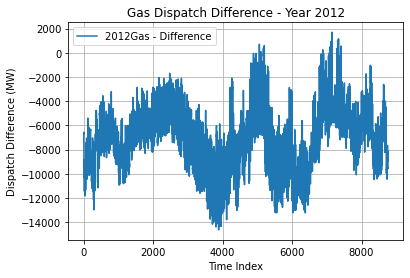

Year: 2012
Gas difference (Emp - Syn), MWh: -61321633.012967564
Gas difference (Emp - Syn), %: -42.38652221649254
Coal difference (Emp - Syn), MWh: 60060833.08089202
Coal difference (Emp - Syn), %: 54.8517368197067
Total Gas, Empirical, MWh: 144672480.322312
Total Coal, Empirical, MWh: 109496684.26782401

Annual Pearson correlation between price difference and gas difference: 0.12846767133469375
Average daily Pearson correlation between price difference and gas difference: -0.026115459322327526



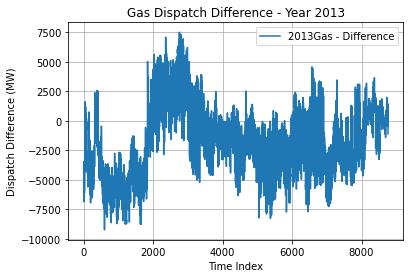

Year: 2013
Gas difference (Emp - Syn), MWh: -13682602.72797203
Gas difference (Emp - Syn), %: -10.198033810229434
Coal difference (Emp - Syn), MWh: 11259201.856045375
Coal difference (Emp - Syn), %: 9.136749358963284
Total Gas, Empirical, MWh: 134169026.91818199
Total Coal, Empirical, MWh: 123229842.624499

Annual Pearson correlation between price difference and gas difference: 0.1647234245859179
Average daily Pearson correlation between price difference and gas difference: 0.2422525315091215



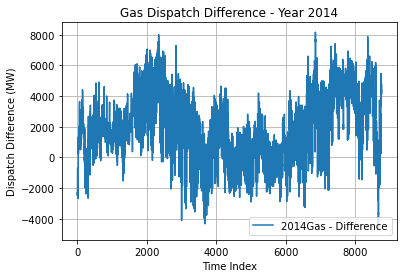

Year: 2014
Gas difference (Emp - Syn), MWh: 16896084.019279454
Gas difference (Emp - Syn), %: 12.089190673604003
Coal difference (Emp - Syn), MWh: -18383147.115314923
Coal difference (Emp - Syn), %: -15.008754976883301
Total Gas, Empirical, MWh: 139761911.905079
Total Coal, Empirical, MWh: 122482825.148581

Annual Pearson correlation between price difference and gas difference: 0.06548739626361177
Average daily Pearson correlation between price difference and gas difference: 0.16975656569415995



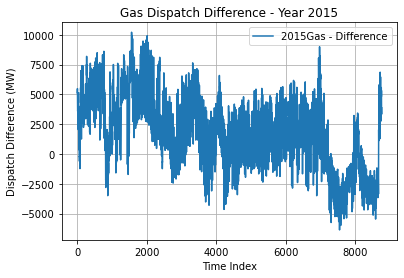

Year: 2015
Gas difference (Emp - Syn), MWh: 15280104.519099183
Gas difference (Emp - Syn), %: 9.101052652582757
Coal difference (Emp - Syn), MWh: -16010900.726005185
Coal difference (Emp - Syn), %: -16.395421032137552
Total Gas, Empirical, MWh: 167893815.170522
Total Coal, Empirical, MWh: 97654709.169233

Annual Pearson correlation between price difference and gas difference: -0.027883688552785026
Average daily Pearson correlation between price difference and gas difference: 0.0781682314855087



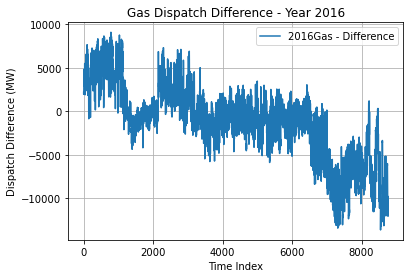

Year: 2016
Gas difference (Emp - Syn), MWh: -11430929.01007723
Gas difference (Emp - Syn), %: -7.464264981851394
Coal difference (Emp - Syn), MWh: 10896320.18144538
Coal difference (Emp - Syn), %: 10.792387077902061
Total Gas, Empirical, MWh: 153142058.030769
Total Coal, Empirical, MWh: 100963022.38599399

Annual Pearson correlation between price difference and gas difference: 0.16051200965067575
Average daily Pearson correlation between price difference and gas difference: 0.0894417673563351



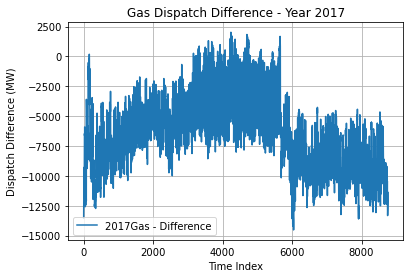

Year: 2017
Gas difference (Emp - Syn), MWh: -54892378.68042296
Gas difference (Emp - Syn), %: -39.53537346619012
Coal difference (Emp - Syn), MWh: 54706046.174227916
Coal difference (Emp - Syn), %: 47.512022880742514
Total Gas, Empirical, MWh: 138843708.476324
Total Coal, Empirical, MWh: 115141479.687242

Annual Pearson correlation between price difference and gas difference: 0.24256748564856642
Average daily Pearson correlation between price difference and gas difference: 0.23507165637465



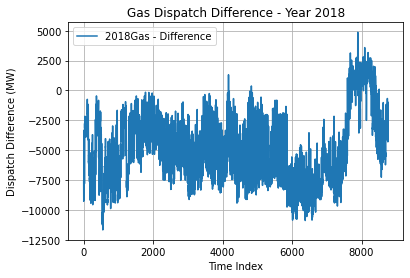

Year: 2018
Gas difference (Emp - Syn), MWh: -42110873.80209593
Gas difference (Emp - Syn), %: -25.18509109299253
Coal difference (Emp - Syn), MWh: 40980188.692516916
Coal difference (Emp - Syn), %: 43.946868073453224
Total Gas, Empirical, MWh: 167205564.77881
Total Coal, Empirical, MWh: 93249395.21064898

Annual Pearson correlation between price difference and gas difference: 0.07417298339035167
Average daily Pearson correlation between price difference and gas difference: 0.07442399328031399



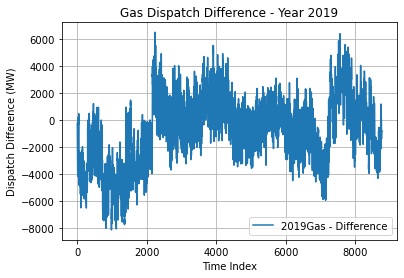

Year: 2019
Gas difference (Emp - Syn), MWh: -6938116.382238675
Gas difference (Emp - Syn), %: -3.816973882460558
Coal difference (Emp - Syn), MWh: 5569710.110956263
Coal difference (Emp - Syn), %: 7.153752742545384
Total Gas, Empirical, MWh: 181770077.44590896
Total Coal, Empirical, MWh: 77857179.46095099

Annual Pearson correlation between price difference and gas difference: 0.03061628156949122
Average daily Pearson correlation between price difference and gas difference: 0.05347806810017748



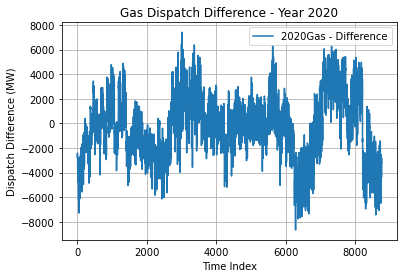

Year: 2020
Gas difference (Emp - Syn), MWh: -2684198.2357613333
Gas difference (Emp - Syn), %: -1.5465998997318746
Coal difference (Emp - Syn), MWh: 466326.93838253245
Coal difference (Emp - Syn), %: 0.6817750410345109
Total Gas, Empirical, MWh: 173554791.787241
Total Coal, Empirical, MWh: 68398945.446131

Annual Pearson correlation between price difference and gas difference: 0.032786722600296914
Average daily Pearson correlation between price difference and gas difference: -0.024804912252626942



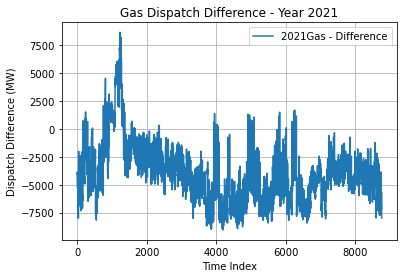

Year: 2021
Gas difference (Emp - Syn), MWh: -34868651.38765326
Gas difference (Emp - Syn), %: -21.206970704275065
Coal difference (Emp - Syn), MWh: 33130213.05753757
Coal difference (Emp - Syn), %: 44.277031196696996
Total Gas, Empirical, MWh: 164420708.048718
Total Coal, Empirical, MWh: 74824829.402765

Annual Pearson correlation between price difference and gas difference: 0.3536719425853599
Average daily Pearson correlation between price difference and gas difference: 0.05121735310356548



In [18]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the range of years
years = range(2012, 2022)

# Iterate over the years
for year in years:
    # Read the files
    synthetic_dispatch = pd.read_csv(f"{year}power.csv")
    empirical_dispatch = pd.read_csv(f"{year}IntGenbyFuel_hourly.csv", parse_dates=[0])

    # Remove useless rows: second row and third row of the synthetic dispatch and reset the index
    synthetic_dispatch = synthetic_dispatch.drop([0, 1])
    synthetic_dispatch = synthetic_dispatch.reset_index(drop=True)
    
    # Calculate the hourly sum of columns containing "gas" (case-insensitive)
    gas_columns_syn = synthetic_dispatch.columns[synthetic_dispatch.columns.str.contains('gas', case=False)]
    synthetic_dispatch["Gas - Total"] = synthetic_dispatch[gas_columns_syn].sum(axis=1)
    gas_columns_emp = empirical_dispatch.columns[empirical_dispatch.columns.str.contains('gas', case=False)]
    empirical_dispatch["Gas - Total"] = empirical_dispatch[gas_columns_emp].sum(axis=1)

    # Calculate the hourly sum of columns containing "coal" (case-insensitive)
    coal_columns_syn = synthetic_dispatch.columns[synthetic_dispatch.columns.str.contains('coal', case=False)]
    synthetic_dispatch["Coal - Total"] = synthetic_dispatch[coal_columns_syn].sum(axis=1)
    coal_columns_emp = empirical_dispatch.columns[empirical_dispatch.columns.str.contains('coal', case=False)]
    empirical_dispatch["Coal - Total"] = empirical_dispatch[coal_columns_emp].sum(axis=1)
    
    # Keep only the "Gas - Total" and "Coal - Total" columns
    synthetic_dispatch = synthetic_dispatch[["Gas - Total", "Coal - Total"]]
    empirical_dispatch = empirical_dispatch[["Gas - Total", "Coal - Total"]]

    # Add a "Time_Index" column to both DataFrames, starting at 1
    synthetic_dispatch["Time_Index"] = range(1, len(synthetic_dispatch) + 1)
    empirical_dispatch["Time_Index"] = range(1, len(empirical_dispatch) + 1)

    # Create a dataframe with the empirical and synthetic dispatch of gas and coal, as well as the difference between them
    dispatch = pd.DataFrame({
        f"{year}Gas - Empirical": empirical_dispatch["Gas - Total"],
        f"{year}Gas - Synthetic": synthetic_dispatch["Gas - Total"],
        f"{year}Gas - Difference": empirical_dispatch["Gas - Total"] - synthetic_dispatch["Gas - Total"],
        f"{year}Coal - Empirical": empirical_dispatch["Coal - Total"],
        f"{year}Coal - Synthetic": synthetic_dispatch["Coal - Total"],
        f"{year}Coal - Difference": empirical_dispatch["Coal - Total"] - synthetic_dispatch["Coal - Total"],
        "Time_Index": synthetic_dispatch["Time_Index"]
    })

    # Save each year dispatch in a unique CSV file using concatenation. Replace existing columns with the new ones
    dispatch_file = pd.read_csv("dispatch_gas_coal.csv")

    # Drop the columns from the dispatch file that already exist in the new dispatch DataFrame
    existing_columns = [col for col in dispatch.columns if col in dispatch_file.columns]
    dispatch_file = dispatch_file.drop(columns=existing_columns)

    # Concatenate the dispatch_file and dispatch DataFrames along the columns axis
    dispatch_file = pd.concat([dispatch_file, dispatch], axis=1)

    # Save the updated DataFrame to the dispatch_gas_coal.csv file
    dispatch_file.to_csv("dispatch_gas_coal.csv", index=False)

    # Calculate the correlation between the price difference and the dispatch difference
    price_diff = pd.read_csv("price_diff.csv")
    price_diff = price_diff[["Time_Index", f"{year}Price Difference"]]

    # Find the Time_Index values that haev NaN values in the price_diff DataFrame, then drop the corresponding row in the dispatch DataFrame and the price_diff DataFrame
    nan_values = price_diff[price_diff[f"{year}Price Difference"].isna()]["Time_Index"].values
    dispatch_pearson = dispatch[~dispatch["Time_Index"].isin(nan_values)]
    price_diff_pearson = price_diff[~price_diff["Time_Index"].isin(nan_values)]
    
    # Annualy
    dispatch_p_annual, _ = pearsonr(price_diff_pearson[f"{year}Price Difference"], dispatch_pearson[f"{year}Gas - Difference"])

    # Daily
    step_size = 24
    pearson_daily = []
    days = []
    for i in range(0, len(price_diff_pearson), step_size):
        y1 = price_diff_pearson[f"{year}Price Difference"].iloc[i:i+step_size]
        y2 = dispatch_pearson[f'{year}Gas - Difference'].iloc[i:i+step_size]
        p_corr, _ = pearsonr(y1, y2)
        pearson_daily.append(p_corr)
        days.append(i/24+1)
    average_daily_pearson = sum(pearson_daily) / len(pearson_daily)

    # Plot the Gas dispatch difference
    ax = dispatch.plot(x="Time_Index", y=f"{year}Gas - Difference", kind="line", title=f"Gas Dispatch Difference - Year {year}")
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Dispatch Difference (MW)")
    ax.grid(True)

    # # Cap the price difference at 100 and plot it
    # price_diff[f"{year}Price Difference"] = price_diff[f"{year}Price Difference"].clip(upper=100)
    # price_diff.plot(x="Time_Index", y=f"{year}Price Difference", kind="line", title=f"Price Difference - Year {year}", ax=ax, secondary_y=True)
    # ax.right_ax.set_ylabel("Price Difference")

    # # On the same plot, plot the pearson correlation between the price difference and the dispatch difference
    # ax.right_ax.plot(days, pearson_daily, color="red", label="Daily Pearson Correlation")
    # ax.right_ax.axhline(average_daily_pearson, color="red", linestyle="--", label="Average Daily Pearson Correlation")
    # ax.right_ax.legend(loc="upper right")
    # ax.right_ax.set_ylim(-1, 1)
    # ax.right_ax.grid(False)

    plt.show()

    print(f"Year: {year}")
    print(f"Gas difference (Emp - Syn), MWh: {dispatch[f'{year}Gas - Difference'].sum()}")
    print(f"Gas difference (Emp - Syn), %: {dispatch[f'{year}Gas - Difference'].sum() / dispatch[f'{year}Gas - Empirical'].sum() * 100}")
    print(f"Coal difference (Emp - Syn), MWh: {dispatch[f'{year}Coal - Difference'].sum()}")
    print(f"Coal difference (Emp - Syn), %: {dispatch[f'{year}Coal - Difference'].sum() / dispatch[f'{year}Coal - Empirical'].sum() * 100}")
    print(f"Total Gas, Empirical, MWh: {dispatch[f'{year}Gas - Empirical'].sum()}")
    print(f"Total Coal, Empirical, MWh: {dispatch[f'{year}Coal - Empirical'].sum()}\n")
    print(f"Annual Pearson correlation between price difference and gas difference: {dispatch_p_annual}")
    print(f"Average daily Pearson correlation between price difference and gas difference: {average_daily_pearson}\n")